In this notebook I investigate the effect of inequality reduction on GHG emissions

In [1]:
%load_ext autoreload
%autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kde import *
from perc import *
%matplotlib inline

from wb_api_wraper import *


pd.set_option('display.max_colwidth', 200)
pd.set_option('display.width', 200)
pd.set_option('display.precision', 2)
pd.set_option('display.max_rows', 500)


In [2]:
datadir = "csvdata/";

In [3]:
any_name_to_wb_name = pd.read_csv("any_name_to_wb_name.csv",index_col="any",squeeze=True)
iso_to_name = pd.read_csv("iso3_to_wb_name.csv",usecols=["iso3","country"],index_col="iso3",squeeze=True)
names_to_iso = pd.read_csv("names_to_iso.csv",usecols=["country","iso3"],index_col="country",squeeze=True)

#Data from World bank API

In [31]:

#TOTAL GDP
#NY.GDP.MKTP.CD 	GDP (current US$) 	World Development Indicators
#NY.GDP.MKTP.CN 	GDP (current LCU) 	World Development Indicators
#NY.GDP.MKTP.KD 	GDP (constant 2005 US$)

#GDP per capital
#NY.GDP.PCAP.KD	GDP per capita (constant 2005 US$)
#NY.GDP.PCAP.CD 	GDP per capita (current US$) 	
#NY.GDP.PCAP.CN 	GDP per capita (current LCU) 
#NY.GDP.PCAP.KD 	GDP per capita (constant 2005 US$)


In [47]:
a=search_wb("gdp")
a[a.source=="World Development Indicators"];

In [34]:
wb_pop = get_wb_mrv("SP.POP.TOTL","wb_pop")
wb_emis = get_wb_mrv("EN.ATM.CO2E.FF.KT","wb_emis")#CO2 emissions from fossil fuels, total;
wb_gdp = get_wb_mrv("NY.GDP.MKTP.KD","gdp").dropna() ; #GDP (constant 2005 US$)

#Data from Maros

In [35]:
#personal data
persdata=pd.read_csv("csvdata/PERSDATA.csv").replace(iso_to_name)  #here emost of weights are 1 but some weights are 0.6
persdata.columns = map(str.lower, persdata.columns)
persdata=persdata.set_index("schema").drop("arm04").reset_index()#drops armenia 2004 since we have armenia 2012
persdata.schema.unique() #countries should apper only once

array(['alb05', 'arm12', 'gha06', 'ind05', 'irq06', 'lbr07', 'mda12',
       'mwi11', 'ner11', 'rwa11', 'sen11', 'sle11', 'vnm12'], dtype=object)

In [37]:
#household data
hhdata = pd.read_csv("csvdata/HHLDDATA.csv").replace(iso_to_name)
hhdata.columns = map(str.lower, hhdata.columns)
hhdata = hhdata.set_index("schema").drop("arm04").reset_index()#drops armenia 2004 since we have armenia 2012
hhdata.schema.unique()#countries should apper only once

array(['alb05', 'arm12', 'bgd05', 'gha06', 'ind05', 'irq06', 'lbr07',
       'mda12', 'mwi11', 'ner11', 'rwa11', 'sen11', 'sle11', 'vnm12'], dtype=object)

In [38]:
persdata;

In [40]:
weight_hh = hhdata.set_index(['country',"hid"])["weight"]

###Population is good

In [41]:
#number of persons per household
nb_people_in_hh =persdata.groupby(["country","hid"])["pid"].count()
nb_people_in_hh.name = "nb_people_in_hh"
nb_people_in_hh.head();
#total number of people in the economy
pop_hh = (weight_hh*nb_people_in_hh).sum(level="country")
(pop_hh/wb_pop).dropna()

country
Albania         0.4
Armenia         0.8
Ghana           0.9
India           0.8
Iraq            0.9
Liberia         0.6
Malawi          0.8
Moldova         0.9
Niger           0.9
Rwanda          0.2
Senegal         0.9
Sierra Leone    1.0
Vietnam         1.0
dtype: float64

###expenditure is not good

In [42]:
#expenditures
expend = pd.read_csv("csvdata/PerCapitaExpenditures.csv").replace(iso_to_name).rename(columns={"value": "expend"})
expend.schema.unique()

array(['alb05', 'arm12', 'gha06', 'ind05', 'irq06', 'lbr07', 'mda12',
       'mwi11', 'ner11', 'rwa11', 'sen11', 'sle11', 'vnm12'], dtype=object)

In [43]:
expend_hh = expend.set_index(["country","hid"]).expend 

In [49]:
expend_pc = 1e3 * (expend_hh*  weight_hh ).sum(level="country") / pop_hh #this suggests that expend_hh is not in the right currency

In [48]:
#GDP per capital
#NY.GDP.PCAP.CD 	GDP per capita (current US$) 	
#NY.GDP.PCAP.CN 	GDP per capita (current LCU) 
#NY.GDP.PCAP.KD 	GDP per capita (constant 2005 US$)
wb_gdp_pc = get_wb_mrv("NY.GDP.PCAP.KD","gdp").dropna() ; #GDP (constant 2005 US$)

In [67]:
1e3*(expend_pc/ get_wb_mrv("NY.GDP.PCAP.KD","gdp")).dropna()

country
Albania          386957.9
Armenia         6064236.6
Ghana            605426.2
India                 8.5
Iraq             117971.9
Liberia          510032.2
Malawi           240675.1
Moldova         8806416.5
Niger            812615.7
Rwanda          6039584.1
Senegal          149269.0
Sierra Leone     287263.6
Vietnam          387896.3
dtype: float64

### emisions is not good

In [59]:
#emissions per household and per capita
emis = pd.read_csv("csvdata/emissionsbyhousehold.csv").replace(iso_to_name).rename(columns={"value": "emis_hh"})
emis.schema.unique() #countries should apper only once (Armenia  is only once in emissionsbyhousehold)

array(['alb05', 'arm12', 'gha06', 'ind05', 'irq06', 'lbr07', 'mda12',
       'mwi11', 'ner11', 'rwa11', 'sen11', 'sle11', 'vnm12'], dtype=object)

In [61]:
emis_hh=emis.set_index(["country","hid"]).emis_hh

In [65]:
((emis_hh*weight_hh).sum(level="country")/wb_emis).dropna()

country
Ghana           1693805.5
Liberia         1788823.8
Malawi          1877452.7
Niger           5696680.3
Rwanda          2473574.5
Senegal         1941522.4
Sierra Leone    1168304.6
dtype: float64

#Gtap

In [14]:
gtap_to_wb_name = pd.read_csv("gtap_to_wb_name.csv",index_col="gtap_region",squeeze=True)
gtap_to_wb_name;

In [15]:
gtap = pd.read_csv("sec_data_gtap.csv").replace(gtap_to_wb_name)
gtap["country"]=gtap.gtap_region.str.upper().str.strip().replace(gtap_to_wb_name)
gtap =gtap.set_index(["country","cpc2"]).drop(["gtap_region"],axis=1)

In [16]:
1e6*(gtap.conso_usd.sum(level="country")/pop_hh ).dropna()#to check whether this is close to gdp per capita

country
Albania    9228.4
Armenia    3335.9
Ghana      1164.1
India      1123.6
Malawi      284.6
Rwanda     2059.4
Senegal     827.0
Vietnam     910.3
dtype: float64

### The problem here is that total expenditures from HH survey do not match gtap 

In [17]:
((expend_hh * weight_hh ).sum(level="country") / gtap.conso_usd.sum(level="country")).dropna()

country
Albania     167499.1
Armenia    4330763.9
Ghana       403299.4
India            9.6
Malawi      230189.0
Rwanda     1224912.5
Senegal     146061.3
Vietnam     459305.3
dtype: float64

###expenses from gtap kindamatch gdpfrom WB

In [27]:
(1e6* gtap.conso_usd.sum(level="country") / 

country
Albania                 1.0
Argentina               0.7
Armenia                 1.1
Australia               0.8
Austria                 0.6
Azerbaijan              1.1
Bahrain                 0.7
Bangladesh              0.7
Belarus                 0.6
Belgium                 0.6
Benin                   1.3
Bolivia                 1.0
Botswana                0.4
Brazil                  1.1
Brunei Darussalam       0.4
Bulgaria                1.0
Burkina Faso            0.6
Cambodia                0.9
Cameroon                0.7
Canada                  0.7
Chile                   0.8
China                   0.4
Colombia                0.9
Costa Rica              0.7
Cote d'Ivoire           0.6
Croatia                 0.8
Cyprus                  0.9
Czech Republic          0.6
Denmark                 0.5
Dominican Republic      0.8
Ecuador                 0.8
Egypt, Arab Rep.        1.4
El Salvador             1.0
Estonia                 0.7
Ethiopia                0.8
Finland     

###emissions directly from gtap are consistent with those from wb api

In [19]:
((gtap.conso_usd*gtap.emissions_g_usd).sum(level="country")/wb_emis).dropna()

country
Benin               1.1
Botswana            0.7
Burkina Faso        1.3
Cote d'Ivoire       1.1
Egypt, Arab Rep.    0.5
Ethiopia            1.5
Ghana               1.6
Guinea              1.5
Kenya               0.8
Madagascar          1.8
Malawi              1.9
Mauritius           0.9
Morocco             0.6
Mozambique          2.6
Namibia             0.7
Nigeria             1.0
Rwanda              1.9
Senegal             1.1
South Africa        0.2
Tanzania            1.1
Togo                1.3
Tunisia             0.6
Uganda              1.3
Zambia              4.2
Zimbabwe            0.9
dtype: float64

###But emissions from HH surveys are not consistent with GTAP

In [68]:
((emis_hh*weight_hh).sum(level="country") / (gtap.conso_usd*gtap.emissions_g_usd).sum(level="country")).dropna()

country
Albania      227221.8
Armenia    15822126.5
Ghana       1058665.9
India        327611.5
Malawi       995219.1
Rwanda      1307396.2
Senegal     1732853.5
Vietnam      767561.6
dtype: float64

###df

In [20]:
#checks sanity with the index
emis_hh[['country',"hid"]].duplicated().sum()  , hhdata[['country',"hid"]].duplicated().sum()

(0, 0)

In [21]:
df= pd.concat([nb_people_in_hh,weight_hh,emis_hh.set_index(["country","hid"])["emis_hh"]],axis=1)

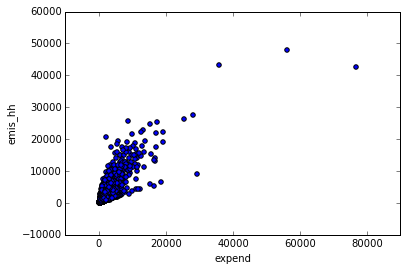

In [22]:
df["expend"] = expend.set_index(["country","hid"]).expend
df.ix["Vietnam"].plot(x="expend",y="emis_hh",kind="scatter")

In [23]:
pov_head = get_wb("SI.POV.2DAY")
pov_head.stack();


todo:a
    
    -find poverty headcount
    -infer exchange rate
    -move distributions

###Data from GTAP and computation in SQL

In [71]:
gtap_emis = pd.read_csv("tot_emis_gtap.csv",header=None,names=["country","emis"],index_col = "country", squeeze=True)

In [74]:
gtap_emis / ((gtap.conso_usd*gtap.emissions_g_usd).sum(level="country"))

country
Albania                 1
Argentina               1
Armenia                 1
Australia               1
Austria                 1
Azerbaijan              1
Bahrain                 1
Bangladesh              1
Belarus                 1
Belgium                 1
Benin                   1
Bolivia                 1
Botswana                1
Brazil                  1
Brunei Darussalam       1
Bulgaria                1
Burkina Faso            1
Cambodia                1
Cameroon                1
Canada                  1
Chile                   1
China                   1
Colombia                1
Costa Rica              1
Cote d'Ivoire           1
Croatia                 1
Cyprus                  1
Czech Republic          1
Denmark                 1
Dominican Republic      1
Ecuador                 1
Egypt, Arab Rep.        1
El Salvador             1
Estonia                 1
Ethiopia                1
Finland                 1
France                  1
Georgia                 1
Germ

###Data from IEA

In [ ]:

iea_emis=pd.read_csv("carbon_emissions_from_iea.csv",skiprows=[1],na_values=[".."]).dropna(axis=1,how="all").dropna().replace(any_name_to_wb_name).set_index("country")
iea_emis = iea_emis.ix[wb_emis.index].astype("float")

In [ ]:
iea_emis

In [ ]:
wb_emis

In [ ]:
iea_emis.iloc[:,-1]

###Comparing various sources

In [ ]:
def wavg(val_col_name, wt_col_name):
    """computes the average of val_col_name weighted by wt_col_name"""
    def inner(group):
        return (group[val_col_name] * group[wt_col_name]).sum() / group[wt_col_name].sum()
    #inner.__name__ = res_name
    return inner

In [ ]:
flat_df =  df.reset_index()
country_list = flat_df.country.unique()dd

In [ ]:
#Categories USD per day categories
income_bins = np.array([0,1,1.25,2,2.5,4]+[10*2.**i for i in range(0,15,1)]) 
income_cut = pd.cut(flat_df["hh_exp_pc"]/365, income_bins)

income_cut.unique()


In [ ]:
flat_df

In [ ]:
#
stats = pd.DataFrame()
grouped =flat_df.groupby(["country",income_cut])
stats["avg_emis_pc"]=grouped.apply(wavg('hh_emi_pc', 'w'))
stats["nb_people0"] =grouped["nb_people"].sum()
#stats.sort_index(inplace=True)
#stats["nb_people1"]=grouped["nb_people"]
stats

In [ ]:
#stats.ix[c]
#country_stats

In [ ]:
#for c in country_list:
#def lift_folks(country_stats):
def lift_folks(country_stats):
    #out = pd.DataFrame(index=country_stats.index)
    emis =pd.DataFrame(index=["emis"])
    out= country_stats.ix[:,["nb_people0"]]
    for i in range(1,10):
        nam = 'min'+str(income_bins[i])
        out[nam] = country_stats["nb_people0"]
        out.ix[i,nam] = country_stats.ix[0:i+1,"nb_people0"].sum()
        out.ix[0:i,nam] =0
        #emis[str(i)]= np.average(country_stats["avg_emis_pc"],weights=out[nam])
    return out
 #   stats.ix[c,[out.columns.values]]=out

In [ ]:
emis_sce_country = pd.DataFrame()
#computes new emissions at once
for c in country_list:
    emis_sce_country[c]= stats.ix[c]["avg_emis_pc"].dot(lift_folks(stats.ix[c,:]))/(stats.ix[c]["nb_people0"].sum())
    
emis_sce_country    

In [ ]:
#emis_sce_country['tot']=emis_sce_country.sum(axis=1)  

In [ ]:
(emis_sce_country/emis_sce_country.ix["nb_people0",:]-1)*100

In [ ]:
#paf = stats.reset_index().groupby("country").apply(lift_folks)
#paf.reset_index().groupby("country").apply(wavg("avg_emis_pc","nb_people1"))
#paf

In [ ]:
#pd.concat([flat_df,pd.get_dummies(income_cut)],axis=1).set_index(["country","hid"])
income_cut = pd.cut(df["hh_exp_pc"]/365, income_bins)

income_dummies= pd.get_dummies(income_cut)
df= pd.concat([df,income_dummies],axis=1)
df

In [ ]:
stats.ix[:,"nb_people1"] = stats.ix[:,"nb_people"]
stats.ix[:,"nb_people1"]

In [ ]:
stats.ix[pd.MultiIndex("ALB)]

In [ ]:
wp(vn["hh_exp_pc"],vn["nb_people"],np.arange(0,1,0.1))

In [ ]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(9,7))
plt.plot((df["hh_exp_pc"]),df["hh_emi_pc"]/df["hh_exp_pc"],color="blue",marker='.',markeredgewidth=1,linestyle='None',markersize=12,clip_on=False)
plt.xlabel("$\$/yr$")
plt.ylabel("$gCO_2/\$$")
plt.xscale("log")

In [ ]:
stats.

In [ ]:
def weighted_rolling_mean(x,y,w,kernel):
    

In [ ]:
from statsmodels.nonparametric.kernel_regression import KernelReg
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0,2*np.pi,100)
y = np.sin(x) + np.random.random(100) * 0.2
kr = KernelReg(y,x,'o')
plt.plot(x, y, '+')
y_pred, y_std = kr.fit(x)
plt.plot(x, y_pred)

In [ ]:
def plot_distribution(y,w,thecolor="red"):
    hist, bin_edges = np.histogram(y,bins=100,weights=w,density=True)
    width = 0.5 * (bin_edges[1] - bin_edges[0])
    center = (bin_edges[:-1] + bin_edges[1:]) / 2
    xs = np.linspace(center.min(),center.max(),300)
    plt.bar(center, hist, align='center', width=width,alpha=0.0,color=thecolor)
    density = gaussian_kde(y,weights=w)
    density._compute_covariance()
    plt.plot(xs,density(xs),linewidth=2,color=thecolor)


In [ ]:
plot_distribution(np.log(vn.hh_emi_pc),vn.w)

